In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### read and summarize data

In [2]:
movie_data = pd.read_csv('../final_data/moviereviews_train.tsv', sep='\t')

In [3]:
print("movie_data is:", type(movie_data))
print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
print("the data types for each of the columns in movie_data:")
print(movie_data.dtypes, "\n")
print("the first 10 rows in movie_data:")
print(movie_data.head(5))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


In [4]:
print("The rate of 'good' movie reviews in the dataset: ")
print(movie_data['sentiment'].mean())

The rate of 'good' movie reviews in the dataset: 
0.5


### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = movie_data.review.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(movie_data.review)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(25000, 131072)


In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
movie_data['punc_count'] = movie_data['review'].str.count("\.")


X_quant_features = movie_data[["word_count", "punc_count"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9
5          89           5
6         112           9
7         132           9
8         163           7
9          43           5
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(25000, 131074)


In [11]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 325)	0.22769982132369695
  (0, 3550)	0.15640750997964029
  (0, 8564)	0.05483304879157904
  (0, 9034)	0.07378155428700128
  (0, 10837)	0.16895279805676006
  (0, 11026)	0.15970735237501926
  (0, 11757)	0.10495253387841272
  (0, 13677)	0.06019646455219527
  (0, 18790)	0.06471277819596864
  (0, 21049)	0.22138856873464122
  (0, 22965)	0.03370439157754295
  (0, 22987)	0.11356488075702073
  (0, 23417)	0.13208722134630463
  (0, 24734)	0.18249502643538026
  (0, 24954)	0.12582955817604333
  (0, 26546)	0.18149808613387974
  (0, 27551)	0.19134395707008087
  (0, 29426)	0.05206317268369082
  (0, 29943)	0.2137109852587048
  (0, 30038)	0.08345030700860545
  (0, 37777)	0.025990300249250874
  (0, 41047)	0.12697908888740234
  (0, 42257)	0.101902653884296
  (0, 43099)	0.09619063434932049
  (0, 43902)	0.02841252699410208
  :	:
  (0, 79266)	0.08345564871152826
  (0, 84037)	0.10719445071171073
  (0, 84380)	0.043005933462820924
  (0, 85040)	0.0582478012185327
  (0, 87587)	0.10280126200845151
  (0, 90340

### Create `X`, scaled matrix of features

In [12]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

(25000, 131074)


In [13]:
# look at an example of a "row" of a sparse matrix, after scaling
print(X[1234])

  (0, 325)	37.769179624610956
  (0, 3550)	48.959416082561496
  (0, 8564)	1.863419893568183
  (0, 9034)	5.446865487660176
  (0, 10837)	61.675214978833914
  (0, 11026)	53.32708548098823
  (0, 11757)	12.588760440909146
  (0, 13677)	1.3882239061048072
  (0, 18790)	3.1949279629324403
  (0, 21049)	23.520256814452825
  (0, 22965)	1.1923842627141756
  (0, 22987)	14.521310810547561
  (0, 23417)	33.09433974490974
  (0, 24734)	2.415154163331848
  (0, 24954)	28.60872619050793
  (0, 26546)	113.92699149806329
  (0, 27551)	19.80431416627204
  (0, 29426)	2.3923573928885884
  (0, 29943)	10.902133568918082
  (0, 30038)	2.989970784356841
  (0, 37777)	0.5446689460590836
  (0, 41047)	17.917875384835646
  (0, 42257)	2.8925947976932656
  (0, 43099)	2.262472836502387
  (0, 43902)	1.0747282625172083
  :	:
  (0, 79266)	3.6682201190648693
  (0, 84037)	10.406322411510791
  (0, 84380)	1.4980136242965825
  (0, 85040)	3.301612408563252
  (0, 87587)	8.80867566225685
  (0, 90340)	0.9624411983686358
  (0, 92716)	2.1444

# Create Training and Test Sets

In [15]:
# create training and test sets
from sklearn.model_selection import train_test_split

# enter an integer for the random_state parameter; any integer will work
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, movie_data['sentiment'], movie_data, test_size= 0.2, random_state=74)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_raw_train.shape)
print(X_raw_test.shape)

(20000, 131074)
(5000, 131074)
(20000,)
(5000,)
(20000, 5)
(5000, 5)


# Fit Models

### MODEL: ordinary least squares

In [16]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 3998, 'TN': 4002, 'FP': 3991, 'FN': 4007, 'Accuracy': 0.33330555787017746, 'Precision': 0.5004381023907873, 'Recall': 0.39848499950164457, 'desc': 'ols_train'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


### MODEL: SVM, linear

In [17]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 4003, 'TN': 3995, 'FP': 3998, 'FN': 4002, 'Accuracy': 0.33322223148070995, 'Precision': 0.5003124609423822, 'Recall': 0.39898335492873516, 'desc': 'svm_train'}


### MODEL: logistic regression

In [18]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 4013, 'TN': 3993, 'FP': 4000, 'FN': 3992, 'Accuracy': 0.3335555370385801, 'Precision': 0.500811181829527, 'Recall': 0.3999800657829164, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 3914, 'TN': 4088, 'FP': 3905, 'FN': 4091, 'Accuracy': 0.333388884259645, 'Precision': 0.5005755211663896, 'Recall': 0.3901126283265225, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [20]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 4020, 'TN': 3988, 'FP': 4005, 'FN': 3985, 'Accuracy': 0.33363886342804766, 'Precision': 0.5009345794392523, 'Recall': 0.4006777633808432, 'desc': 'prc_train'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


### MODEL: Ridge Regression Classifier

In [21]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10033.0, 'Neg': 13969.0, 'TP': 4013, 'TN': 3993, 'FP': 4000, 'FN': 3992, 'Accuracy': 0.3335555370385801, 'Precision': 0.500811181829527, 'Recall': 0.3999800657829164, 'desc': 'rdg_train'}


### ROC plot to compare performance of various models and fits

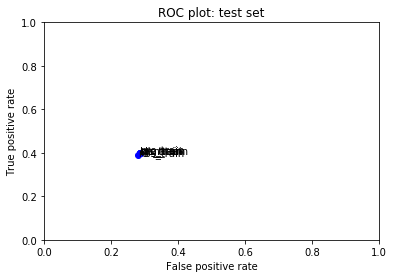

In [22]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [23]:
movie_data.loc[0, "review"]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [24]:
ridge_predictions = rdg.predict(X_train)

In [25]:
ridge_predictions.shape

(20000,)

In [26]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (movie_data.loc[i, "sentiment"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(movie_data.loc[i, "review"])
                print('* * * * * * * * * ')

Examples of false positives:
52
Yikes. This is pretty bad. The play isn't great to begin with, and the decision to transfer it to film does it no favours - especially as Peploe doesn't decide how she wants to treat the material's theatrical origins (we get occasional glances of an observing theatre audience etc.) and has decided to go with a jumpy editing style that is intended to keep reminding you that you're watching a film, whereas in fact it only serves to remind you that you are watching a very poor film by a director who is overwhelmed by her material. Mira Sorvino's central performance is breath-takingly poor: stage-y and plummy, it's as if she's playing the part via Helena Bonham-Carter's Merchant Ivory oeuvre. Only Fiona Shaw delivers a performance of note - and it may be that her theatrical pedigree means that she is best able to handle the material - but it's hard to watch a film for one performance alone, even if that performance is as light, truthful and entire as Shaw's.

18783
The London Underground has something inherently creepy about it, with its long winding tunnels, the escalators taking you deeper and deeper underground, and of course the rats roaming the tracks.It a source of wonder that it is not used in horror films more often. It was used in the seventies horror Deathline aka Raw Meat, featuring a cannibalistic tribe living in a disused tunnel, and the celebrated chase sequence in American Werewolf in London. So I was pleased to see that someone else had tried to capitalise on the atmosphere of the tube at night with the recent UK production Creep.<br /><br />I thought the film started off well, with a highly effective credit sequence that was genuinely unnerving, followed by a scene in the sewers that sets up the premise of there being something evil lurking below the streets of London. However, Creep went downhill from here, and I found myself wishing that I'd switched it off after this opening scene, leaving me with a favourable impression

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [27]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 254, 'TN': 245, 'FP': 246, 'FN': 244, 'Accuracy': 0.05537676173565642, 'Precision': 0.508, 'Recall': 0.10295905958654236, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [28]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 247, 'TN': 259, 'FP': 232, 'FN': 251, 'Accuracy': 0.056153590056597494, 'Precision': 0.5156576200417536, 'Recall': 0.10012160518848805, 'desc': 'svm_test'}


### MODEL: logistic regression

In [29]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 240, 'TN': 268, 'FP': 223, 'FN': 258, 'Accuracy': 0.0563755410054378, 'Precision': 0.5183585313174947, 'Recall': 0.09728415079043372, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [30]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 244, 'TN': 261, 'FP': 230, 'FN': 254, 'Accuracy': 0.05604261458217734, 'Precision': 0.5147679324894515, 'Recall': 0.09890555330360762, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [31]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 249, 'TN': 257, 'FP': 234, 'FN': 249, 'Accuracy': 0.056153590056597494, 'Precision': 0.515527950310559, 'Recall': 0.10093230644507499, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [32]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2467.0, 'Neg': 6544.0, 'TP': 248, 'TN': 251, 'FP': 240, 'FN': 250, 'Accuracy': 0.05537676173565642, 'Precision': 0.5081967213114754, 'Recall': 0.10052695581678152, 'desc': 'rdg_test'}


### ROC plot to compare performance of various models and fits

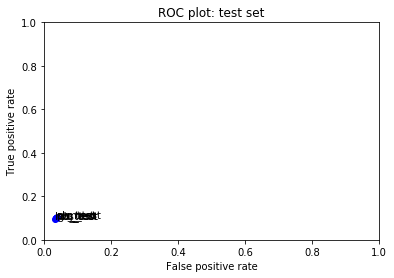

In [33]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()